In [1]:
import pandas as pd
import numpy as np
import torch

from matplotlib import pyplot as plt

In [2]:
x23 = pd.read_csv('complete_d=0.23.csv')['FL1-A'].to_numpy()
x33 = pd.read_csv('complete_d=0.33.csv')['FL1-A'].to_numpy()

In [3]:
xp = np.concatenate((x23,x33))
w = np.abs(xp.min()-xp.max())

In [4]:
gaussian_loglike = lambda x,mu,sig: -(1/2)*(((x-mu)/sig)**2) - np.log(sig) - (1/2)*np.log(2*np.pi)
def loglikelihood(x,mu,sig,rho):
    return np.logaddexp(np.log(rho)+gaussian_loglike(x,mu,sig),
                        np.log(1-rho)-np.log(w))


In [6]:
def total_metric(x_23,x_33,mu,sig,rho_23,rho_33):
    return (loglikelihood(x_23,mu,sig,rho_23)).sum()+(loglikelihood(x_33,mu,sig,rho_33)).sum() + (np.log(rho_23)+np.log(1-rho_23)+np.log(rho_33)+np.log(1-rho_33))

In [7]:
y1,y2,r23,r33 = (np.log(1000),np.log(.1),.85,.95)
gauss_par = lambda y1,y2,r23,r33: (np.exp(y1),np.exp(y2+y1),r23,r33)

proposey1 = lambda y1: y1+np.random.normal(0,.5)
proposey2 = lambda y2: y2+np.random.normal(0,.10)
proposerho = lambda rho: (rho + np.random.choice((-1,1),1,p=(.5,.5)) * np.random.choice(4,1,p=(.01,.68,.27,.04))/100)[0]%1

In [8]:
lp = total_metric(x23,x33,*gauss_par(y1,y2,r23,r33))
lp

-2694453.0313848006

In [9]:
lps=[]
params=[]

In [10]:
for i in range (500):
    for j in range(10):
        y1prop = proposey1(y1)
        lpprop = total_metric(x23,x33,*gauss_par(y1prop,y2,r23,r33))
        if np.random.rand()<lpprop-lp:
            y1=y1prop
            lp=lpprop

        y2prop = proposey2(y2)
        lpprop = total_metric(x23,x33,*gauss_par(y1,y2prop,r23,r33))
        if np.random.rand()<lpprop-lp:
            y2=y2prop
            lp=lpprop
    
    u = np.random.rand()
    if u<.5:
        r23prop = proposerho(r23)
        lpprop = total_metric(x23,x33,*gauss_par(y1,y2,r23prop,r33))
        if np.random.rand()<=lpprop-lp:
            r23=r23prop
            lp=lpprop
    else:
        r33prop = proposerho(r33)
        lpprop = total_metric(x23,x33,*gauss_par(y1,y2,r23,r33prop))
        if np.random.rand()<=lpprop-lp:
            r33=r33prop
            lp=lpprop

    params.append(gauss_par(y1,y2,r23,r33))
    print(params[-1],lp)
    lps.append(lp)

(1422.3361421176523, 223.67882935984187, 0.85, 0.94) -2267727.2560770637
(1422.3361421176523, 416.355707007531, 0.84, 0.94) -2102405.775545299
(1665.223169547927, 600.4820618623108, 0.84, 0.94) -2084175.0135069448


(1493.4330941450692, 675.3061442126002, 0.84, 0.94) -2075868.6540803823
(1506.5563794620753, 670.6308107178194, 0.84, 0.94) -2075771.6229137413
(1506.5563794620753, 670.6308107178194, 0.84, 0.97) -2075545.0182771224
(1506.5563794620753, 678.2536386759442, 0.84, 0.97) -2075524.0216466933
(1509.1357778732315, 679.4148871906439, 0.83, 0.97) -2074477.855613202
(1509.1357778732315, 679.4148871906439, 0.83, 0.97) -2074477.855613202
(1509.1357778732315, 679.4148871906439, 0.82, 0.97) -2073567.3503471417
(1509.1357778732315, 679.4148871906439, 0.82, 0.97) -2073567.3503471417
(1509.1357778732315, 679.4148871906439, 0.7999999999999999, 0.97) -2072062.5859504708
(1509.1357778732315, 673.8902695560575, 0.7999999999999999, 0.97) -2072047.3120911797
(1509.1357778732315, 673.8902695560575, 0.7999999999999999, 0.97) -2072047.3120911797
(1509.1357778732315, 673.8902695560575, 0.7999999999999999, 0.97) -2072047.3120911797
(1509.1357778732315, 673.8902695560575, 0.7999999999999999, 0.97) -2072047.3120911

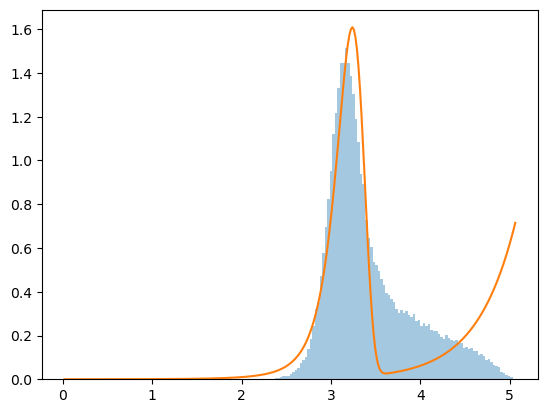

In [11]:
h = np.histogram(np.concatenate((np.log10(x23[x23>0]),np.log10(x33[x33>0]))),bins=99)

plt.hist(np.log10(x23[x23>0]),bins=h[1],alpha=.4,density=True)
#plt.hist(np.log10(x33[x33>0]),bins=h[1],alpha=.4,density=True)

xx=np.linspace(0,np.log10(x23).max(),301)[1:]
y = 10**xx
plt.plot(xx,np.exp(loglikelihood(y,np.exp(y1),np.exp(y1+y2),r23)+np.log(y))*np.log(10))
plt.plot
plt.show()

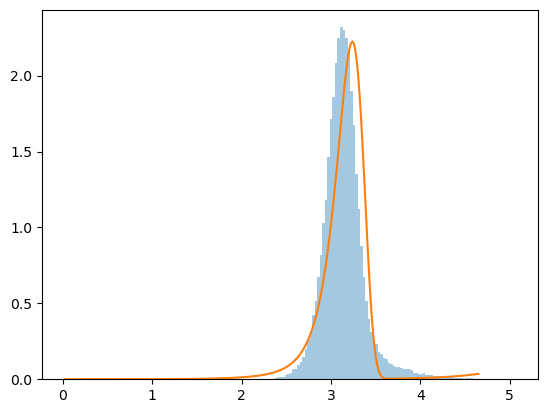

In [12]:
h = np.histogram(np.concatenate((np.log10(x23[x23>0]),np.log10(x33[x33>0]))),bins=99)

plt.hist(np.log10(x33[x33>0]),bins=h[1],alpha=.4,density=True)
#plt.hist(np.log10(x33[x33>0]),bins=h[1],alpha=.4,density=True)

xx=np.linspace(0,np.log10(x33).max(),301)[1:]
y = 10**xx
plt.plot(xx,np.exp(loglikelihood(y,np.exp(y1),np.exp(y1+y2),r33)+np.log(y))*np.log(10))
plt.plot
plt.show()

In [13]:
lis = [[[[(mu,sig,rr23,rr33) for mu in 1496+np.arange(-20,21)] for sig in 641+np.arange(-20,21)] for rr23 in np.arange(60,91)/100]for rr33 in np.arange(90,100)/100]
lis = np.array(lis).reshape(-1,4)

In [14]:
lps = [total_metric(x23,x33,*l) for l in lis ]

In [ ]:
lis[np.argmax(lps)]

array([1.497e+03, 6.420e+02, 6.900e-01, 9.600e-01])

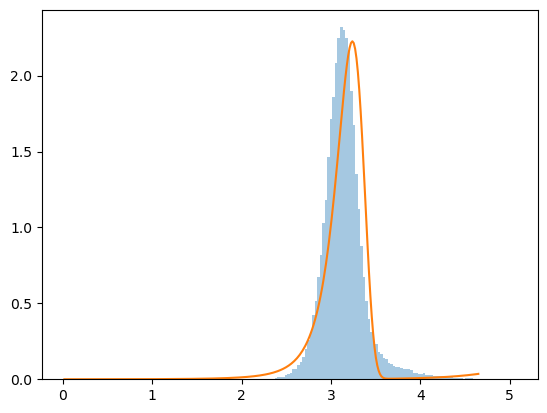

In [ ]:
h = np.histogram(np.concatenate((np.log10(x23[x23>0]),np.log10(x33[x33>0]))),bins=99)

plt.hist(np.log10(x33[x33>0]),bins=h[1],alpha=.4,density=True)
xx=np.linspace(0,np.log10(x33).max(),301)[1:]
y = 10**xx
plt.plot(xx,np.exp(loglikelihood(y,1497,642,.96)+np.log(y))*np.log(10))
plt.plot
plt.show()

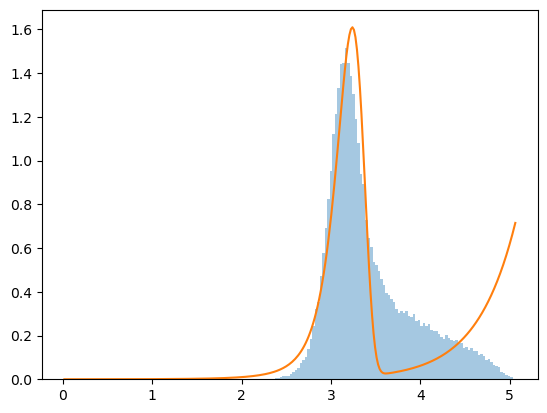

In [ ]:
h = np.histogram(np.concatenate((np.log10(x23[x23>0]),np.log10(x33[x33>0]))),bins=99)

plt.hist(np.log10(x23[x23>0]),bins=h[1],alpha=.4,density=True)
xx=np.linspace(0,np.log10(x23).max(),301)[1:]
y = 10**xx
plt.plot(xx,np.exp(loglikelihood(y,1497,642,.69)+np.log(y))*np.log(10))
plt.plot
plt.show()